In [1]:
from dataclasses import dataclass

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data = load_boston()
X = pd.DataFrame(data["data"], columns=data["feature_names"])
y = pd.DataFrame(data["target"], columns=["MEDV"])
df = pd.concat([X, y], axis=1)
df_train, df_test = train_test_split(df, test_size=0.1, random_state=1)

In [3]:
print(df_train.shape)
df_train.head()

(455, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
242,0.10290,30.0,4.93,0.0,0.428,6.358,52.9,7.0355,6.0,300.0,16.6,372.75,11.22,22.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
168,2.30040,0.0,19.58,0.0,0.605,6.319,96.1,2.1000,5.0,403.0,14.7,297.09,11.10,23.8
490,0.20746,0.0,27.74,0.0,0.609,5.093,98.0,1.8226,4.0,711.0,20.1,318.43,29.68,8.1
62,0.11027,25.0,5.13,0.0,0.453,6.456,67.8,7.2255,8.0,284.0,19.7,396.90,6.73,22.2


## Generate Tree

In [4]:
def sum_squared_error(y_true, y_pred):
    if len(y_true) > 0:
        return np.square(y_true - y_pred).sum()
    else:
        return 0

In [5]:
df_train

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
242,0.10290,30.0,4.93,0.0,0.428,6.358,52.9,7.0355,6.0,300.0,16.6,372.75,11.22,22.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
168,2.30040,0.0,19.58,0.0,0.605,6.319,96.1,2.1000,5.0,403.0,14.7,297.09,11.10,23.8
490,0.20746,0.0,27.74,0.0,0.609,5.093,98.0,1.8226,4.0,711.0,20.1,318.43,29.68,8.1
62,0.11027,25.0,5.13,0.0,0.453,6.456,67.8,7.2255,8.0,284.0,19.7,396.90,6.73,22.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,0.03548,80.0,3.64,0.0,0.392,5.876,19.1,9.2203,1.0,315.0,16.4,395.18,9.25,20.9
72,0.09164,0.0,10.81,0.0,0.413,6.065,7.8,5.2873,4.0,305.0,19.2,390.91,5.52,22.8
396,5.87205,0.0,18.10,0.0,0.693,6.405,96.0,1.6768,24.0,666.0,20.2,396.90,19.37,12.5
235,0.33045,0.0,6.20,0.0,0.507,6.086,61.5,3.6519,8.0,307.0,17.4,376.75,10.88,24.0


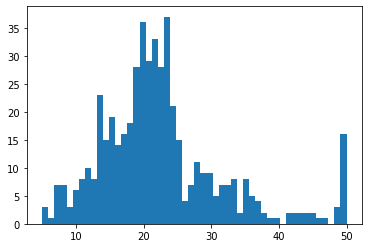

In [6]:
plt.hist(df["MEDV"], 50)
plt.show()

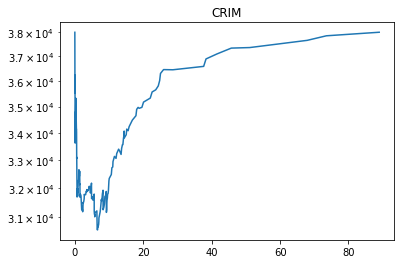

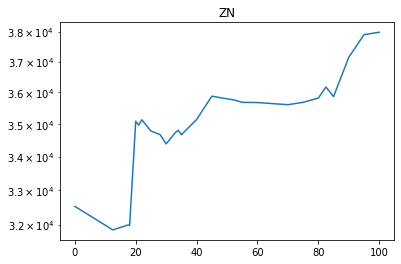

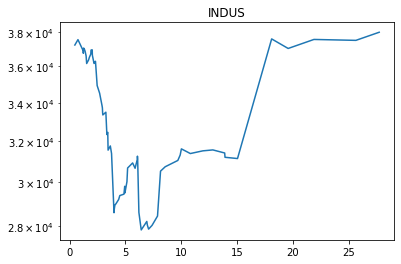

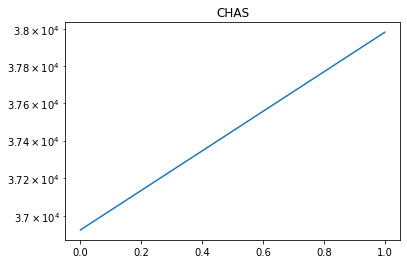

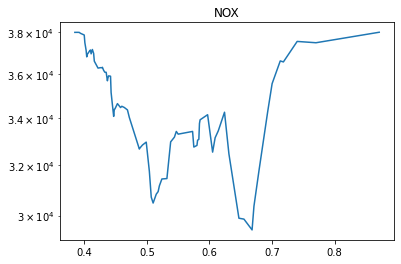

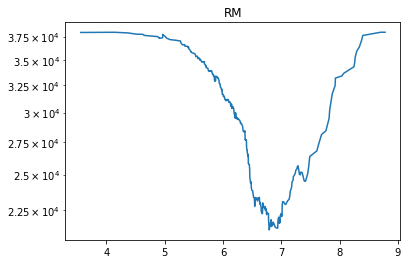

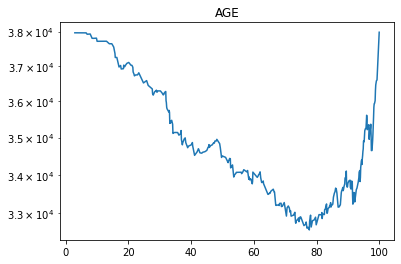

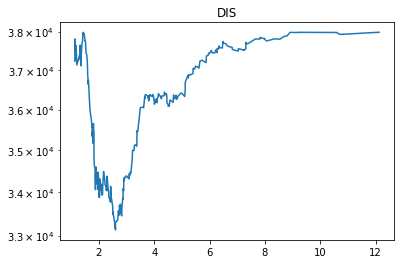

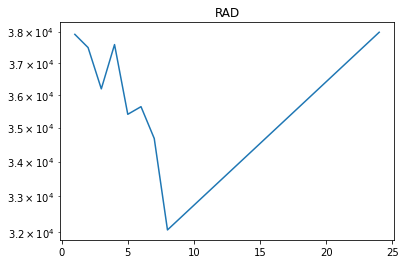

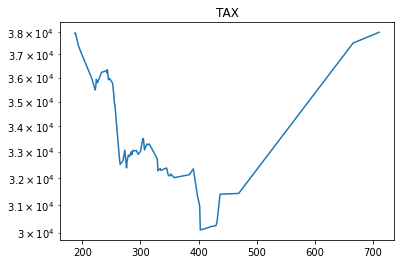

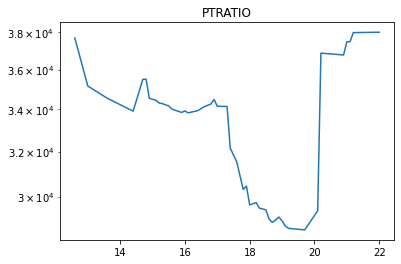

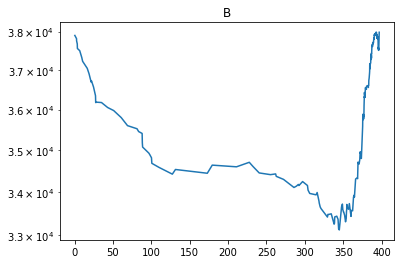

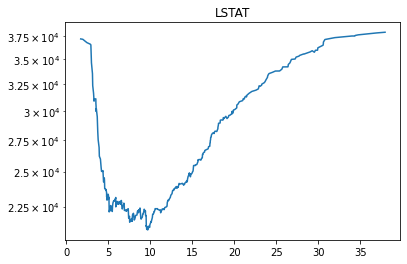

In [17]:
for var in df_train.columns[:-1]:
    var_vals = df_train[var].unique()
    thresh = np.sort(var_vals)
#     breakpoint()
    sse = np.zeros_like(thresh)
    for i, t in enumerate(thresh):
        idx = df[var] <= t
        l_val = df_train.loc[idx, "MEDV"].mean()
        sse_l = sum_squared_error(df_train.loc[idx, "MEDV"], l_val)
        r_val = df_train.loc[~idx, "MEDV"].mean()
        sse_r = sum_squared_error(df_train.loc[~idx, "MEDV"], r_val)
        sse[i] = sse_l + sse_r

    plt.plot(thresh, sse)
    plt.plot
    plt.yscale("log")
    plt.title(var)
    plt.show()

In [8]:
def get_thresh_per_var(df, var, y_col):
    var_vals = df[var].unique()
    thresh = np.sort(var_vals)
    sse = np.zeros_like(thresh)
    l_val = np.zeros_like(thresh)
    r_val = np.zeros_like(thresh)
    for i, t in enumerate(thresh):
        idx = df[var] <= t
        l_val[i] = df.loc[idx, y_col].mean()
        sse_l = sum_squared_error(df.loc[idx, y_col], l_val[i])
        r_val[i] = df.loc[~idx, y_col].mean()
        sse_r = sum_squared_error(df.loc[~idx, y_col], r_val[i])
        sse[i] = sse_l + sse_r
    
    idx = sse.argmin()
    return thresh[idx], sse.min(), l_val[idx], r_val[idx]

def get_thresh(df, y_col):
    best_sse = float("inf")
    for col in df.columns:
        if col == y_col:
            continue
        t, sse, l_val, r_val = get_thresh_per_var(df, col, y_col)
        if sse < best_sse:
            best_sse = sse
            best_col = col
            best_thresh = t
            best_l_val = l_val
            best_r_val = r_val
            
    return best_col, best_thresh, best_l_val, best_r_val

class Node:
    def __init__(self, val):
        self.val = val
        self.left = None
        self.right = None

def splitting(df, y_col, depth=1):
    if len(df) < LEAF_THRESH or depth > DEPTH_THRESH:
        return None
    print(df.shape, depth)
    best_col, thresh, l_val, r_val = get_thresh(df, y_col)

    node = Node((best_col, thresh, l_val, r_val))

    idx = df[best_col] <= thresh
    node.left = splitting(df[idx], y_col, depth+1)
    node.right = splitting(df[~idx], y_col, depth+1)
    
    return node

In [9]:
LEAF_THRESH = 20
DEPTH_THRESH = 3
tree = splitting(df_train, "MEDV")

(455, 14) 1
(191, 14) 2
(165, 14) 3
(26, 14) 3
(264, 14) 2
(136, 14) 3
(128, 14) 3


In [10]:
def print_tree(tree, tab=""):
    print(tab + str(tree.val))
    if tree.left:
        print_tree(tree.left, tab+"\t")
    if tree.right:
        print_tree(tree.right, tab+"\t")
        
print_tree(tree)

('LSTAT', 9.71, 29.738743455497364, 17.354545454545462)
	('RM', 7.42, 27.395757575757568, 44.607692307692304)
		('DIS', 1.3567, 50.0, 26.689374999999984)
		('CRIM', 2.01019, 45.516000000000005, 21.9)
	('LSTAT', 16.03, 20.222794117647062, 14.307031249999996)
		('B', 100.63, 13.25, 20.54461538461539)
		('NOX', 0.597, 17.829545454545457, 12.461904761904758)


In [11]:
def predict(row, tree=tree):
    col, thresh, l_val, r_val = tree.val
    if row[col] <= thresh:
        ans = l_val
        if tree.left:
            return predict(row, tree.left)
        else:
            return ans
    else:
        ans = r_val
        if tree.right:
            return predict(row, tree.right)
        else:
            return ans

In [12]:
from sklearn.metrics import mean_squared_error

In [13]:
y_pred = df_test.apply(predict, axis=1)
mean_squared_error(y_pred, df_test["MEDV"])

15.301130071406932

In [14]:
mean_squared_error(df_test["MEDV"], df_train["MEDV"].mean()*np.ones_like(df_test["MEDV"]))

92.84966098534088

In [15]:
1 - mean_squared_error(y_pred, df_test["MEDV"]) / mean_squared_error(df_test["MEDV"], df_train["MEDV"].mean()*np.ones_like(df_test["MEDV"]))

0.835205321063879